In [1]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [2]:
# work on incorporating lag somehow into the models
import pandas as pd
import matplotlib.pyplot as plt

In [196]:
dataset0 = pd.read_csv('dataset_interpolated.csv').set_index('Year (negative values = BC)')

dataset = dataset0.drop(dataset0[dataset0.index < 1900].index)
dataset.head()

,Temp interpolated,CO2 interpolated,N2O interpolated,Methane interpolated
Year (negative values = BC),,,,
1900,2.366667,296.700000,277.904348,862.400000
1901,2.030000,296.066667,278.169565,868.400000
1902,1.930000,295.433333,278.434783,871.672222
1903,1.840000,294.800000,278.700000,874.944444
1904,1.760000,296.175000,278.852941,878.216667


In [197]:
# check the correlation between the features and the Temperature.  
# The CO2 is the most correlated
dataset.corr()[['Temp interpolated']].sort_values('Temp interpolated')

,Temp interpolated
Methane interpolated,0.880052
N2O interpolated,0.906921
CO2 interpolated,0.907414
Temp interpolated,1.000000


In [198]:
dataset.head()

,Temp interpolated,CO2 interpolated,N2O interpolated,Methane interpolated
Year (negative values = BC),,,,
1900,2.366667,296.700000,277.904348,862.400000
1901,2.030000,296.066667,278.169565,868.400000
1902,1.930000,295.433333,278.434783,871.672222
1903,1.840000,294.800000,278.700000,874.944444
1904,1.760000,296.175000,278.852941,878.216667


In [199]:
# decide on a train and test dataset
# let's test on the last 50 years of data and train on all the rest...
train = dataset[dataset.index < 2000]

In [200]:
test = dataset[dataset.index > 1999]

In [201]:
# split into input and outputs
X, y = dataset.drop("Temp interpolated", axis=1), dataset['Temp interpolated']
X_train, y_train = train.drop("Temp interpolated", axis=1), train['Temp interpolated']
X_test, y_test = test.drop("Temp interpolated", axis=1), test['Temp interpolated']

In [202]:
# scale the data
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_scaled = X_scaler.transform(X)

In [203]:
# reshape input to be 3D [samples, timesteps, features]
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
print(X_train_scaled.shape, y_train.shape, X_test_scaled.shape, y_test.shape, X_scaled.shape, y.shape)

(101, 1, 3) (101,) (16, 1, 3) (16,) (117, 1, 3) (117,)


In [204]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LSTM

In [205]:
model = Sequential()
model.add(LSTM(5, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
model.add(LSTM(5))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_data=(X_test_scaled, y_test), verbose=2, shuffle=False)


Train on 101 samples, validate on 16 samples
Epoch 1/100
101/101 - 7s - loss: 4.7702 - val_loss: 7.6192
Epoch 2/100
101/101 - 0s - loss: 4.6590 - val_loss: 7.4544
Epoch 3/100
101/101 - 0s - loss: 4.5547 - val_loss: 7.2859
Epoch 4/100
101/101 - 0s - loss: 4.4508 - val_loss: 7.1155
Epoch 5/100
101/101 - 0s - loss: 4.3458 - val_loss: 6.9420
Epoch 6/100
101/101 - 0s - loss: 4.2389 - val_loss: 6.7639
Epoch 7/100
101/101 - 0s - loss: 4.1293 - val_loss: 6.5805
Epoch 8/100
101/101 - 0s - loss: 4.0164 - val_loss: 6.3910
Epoch 9/100
101/101 - 0s - loss: 3.9001 - val_loss: 6.1954
Epoch 10/100
101/101 - 0s - loss: 3.7799 - val_loss: 5.9937
Epoch 11/100
101/101 - 0s - loss: 3.6559 - val_loss: 5.7861
Epoch 12/100
101/101 - 0s - loss: 3.5277 - val_loss: 5.5731
Epoch 13/100
101/101 - 0s - loss: 3.3955 - val_loss: 5.3546
Epoch 14/100
101/101 - 0s - loss: 3.2595 - val_loss: 5.1310
Epoch 15/100
101/101 - 0s - loss: 3.1198 - val_loss: 4.9030
Epoch 16/100
101/101 - 0s - loss: 2.9767 - val_loss: 4.6733
Epoc

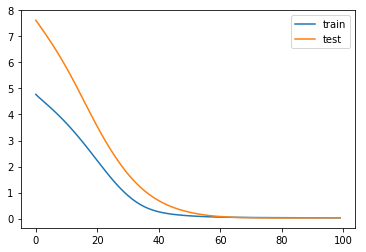

In [206]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig('lstm loss.png')

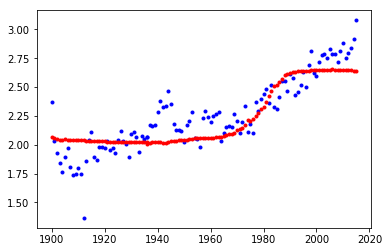

In [207]:
plt.plot(dataset['Temp interpolated'], 'b.')
plt.plot(y_train.index, model.predict(X_train_scaled),'r.')
plt.plot(y_test.index, model.predict(X_test_scaled),'r.')

In [208]:
loss = model.evaluate(X_scaled, y)
print(loss)

117/117 [==============================] - 0s 102us/sample - loss: 0.0289
0.02891914242416875


In [209]:
X_predict_20 = pd.read_csv('predicted_greenhouse_20.csv').set_index('Years Predicted')
X_predict_100 = pd.read_csv('predicted_greenhouse_100.csv').set_index('Years Predicted')
X_predict_100.drop(X_predict_100.columns[[0]], axis=1, inplace=True)
X_predict_20.drop(X_predict_20.columns[[0]], axis=1, inplace=True)
X_predict_20.head()

,CO2 interpolated,N2O interpolated,Methane interpolated
Years Predicted,,,
2016,400.958502,328.381230,1798.461159
2017,402.955437,329.215947,1800.653256
2018,404.952371,330.050663,1802.845353
2019,406.949306,330.885379,1805.037450
2020,408.946240,331.720095,1807.229547


In [210]:
X_predict_20_scaled = X_scaler.transform(X_predict_20)
X_predict_100_scaled = X_scaler.transform(X_predict_100)

In [211]:
# reshape input to be 3D [samples, timesteps, features]
X_predict_20_scaled = X_predict_20_scaled.reshape((X_predict_20_scaled.shape[0], 1, X_predict_20_scaled.shape[1]))
X_predict_100_scaled = X_predict_100_scaled.reshape((X_predict_100_scaled.shape[0], 1, X_predict_100_scaled.shape[1]))
print(X_predict_20_scaled.shape, X_predict_100_scaled.shape)

(10, 1, 3) (10, 1, 3)


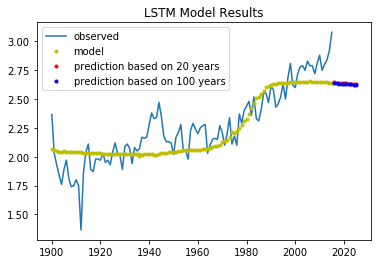

In [212]:
plt.plot(dataset['Temp interpolated'], label='observed')
plt.plot(y.index, model.predict(X_scaled),'y.', label='model')
plt.plot(X_predict_20.index, model.predict(X_predict_20_scaled), 'r.', label='prediction based on 20 years')
plt.plot(X_predict_100.index, model.predict(X_predict_100_scaled), 'b.', label='prediction based on 100 years')
plt.legend()
plt.title('LSTM Model Results')
plt.savefig('future_prediction_deep_recent.png')